In [1]:
# %cd ~/PycharmProjects/muse
%cd /iliad/u/belkhale/muse
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np


def sweep_from_arr(arr):
    s = "[[[ "
    for a in arr:
        s = s + str(a) + " "
    s = s + "]]]"
    return s


/iliad/u/belkhale/muse


In [13]:
# show the state diversity needed?

def plot_2d_state_heatmap(data, t1=None, t2=None, xy_key='robot0_eef_pos', done_key='done', n_bins=30, vmax=200, num_rollouts=None, log=True, ax=None):
    xy = data[xy_key]

    splits = data[done_key].nonzero()[0][:-1] + 1
    episodes = np.split(xy, splits, axis=0)
    if num_rollouts is not None:
        episodes = episodes[:num_rollouts]

    if t1 is not None:
        if t2 is None:
            episodes = [ep[t1:] for ep in episodes]
        else:
            episodes = [ep[t1:t2] for ep in episodes]

    partial_xy = np.concatenate(episodes)
    x, y = partial_xy[..., 0], partial_xy[..., 1]
    
    if log:
#         norm = colors.LogNorm(vmin=1, vmax=vmax+1)
        norm = colors.FuncNorm((lambda v: np.log(v + 1) / np.log(vmax + 1), lambda v: np.exp(v*np.log(vmax+1))),
                               vmin=0, vmax=vmax)
    else:
        norm = None
    
    if ax is not None:
        return ax.hist2d(x, y, bins=(n_bins, n_bins), cmap=plt.cm.jet, 
                           norm=norm)[-1]
    else:
        plt.hist2d(x, y, bins=(n_bins, n_bins), cmap=plt.cm.jet, 
                           norm=norm)
        plt.colorbar()
        plt.show()

Loading human_square_30k.npz


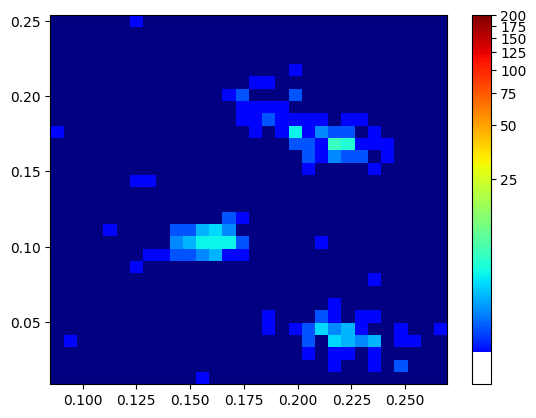

In [14]:
name = 'human_square_30k.npz'
file = f'data/hvs/{name}'
print("Loading", name)
plot_2d_state_heatmap(dict(np.load(file, allow_pickle=True)), t1=-1)

# LEARNED

In [5]:
def compute_success_rate(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    if max_steps is not None:
        # only look at max reward over first "max_steps" steps
        rew_chunks = [r[:max_steps] for r in rew_chunks]
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_return = np.array([np.max(rews) for rews in rew_chunks])
    return np.mean(each_return)
    
def compute_traj_len(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_len = np.array([len(rews) for rews in rew_chunks])
    return np.mean(each_len)

def compute_traj_std(path, num_rollouts, max_steps=None):
    data = dict(np.load(path, allow_pickle=True))
    splits = np.nonzero(data['done'])[0][:-1] + 1
    rew_chunks = np.split(data['reward'].reshape(-1), splits)
    assert len(rew_chunks) == num_rollouts, len(rew_chunks)
    each_len = np.array([len(rews) for rews in rew_chunks])
    return np.std(each_len)
    

In [22]:
# extract success rates for each set of rollouts
import os
from configs.utils import hr_name

def print_metric(noise_type='s', prefix="best_", num_rollouts=100, dset_override=None, metric_fn=compute_success_rate):

    s_noises = [0.05, 0.1, 0.2]
    typed_noises = {
        'h': [0],  # human has no noise
        'p': [0, 0.005, 0.01, 0.02],
        's': s_noises,
    }[noise_type]

    dset_suffs = ['', '-first100', '-first50']
    if dset_override is not None:
        dset_suffs = [dset_override]
    
    batch_sizes = [256 for _ in dset_suffs]

    for batch_size, suff in zip(batch_sizes, dset_suffs):
        success = np.empty((len(typed_noises), len(s_noises)), dtype=np.float32)
        for i, n in enumerate(typed_noises):
            hr_s_sweep = sweep_from_arr(s_noises)
            # special case for zero noise
            if n == 0:
                noise = ""
            else:
                noise = f"_l{noise_type}n{hr_name(n)}"

            save_names = [f"{prefix}eval{num_rollouts}_lsn{hr_name(inner_s)}.npz" for inner_s in s_noises]
            hr_names = sweep_from_arr(save_names)

            # single dataset overrides the list of suffixes.
            if dset_override is not None:
                dset = suff
            else:
                assert noise_type != 'h', "Human dataset requires dset override!"
            dset = f"scripted_rm{noise}_square_200ep{suff}"

            exp_name = f'experiments/hvs/velact_b{batch_size}_h10_{dset}_bc-l2_mlp400-d2'
            for j, file in enumerate(save_names):
                path = f"{exp_name}/{file}"
                assert os.path.exists(path), path
                success[i, j] = metric_fn(path, num_rollouts)

        print(f"Suff='{suff}'...")
        print(success)
        print('------------------------------')


In [23]:
print('SYSTEM NOISE')
print_metric(noise_type='s', prefix='best_')
print('\nPOLICY NOISE')
print_metric(noise_type='p', prefix='best_')

SYSTEM NOISE
Suff=''...
[[0.61 0.59 0.31]
 [0.76 0.82 0.73]
 [0.62 0.7  0.85]]
------------------------------
Suff='-first100'...
[[0.73 0.62 0.45]
 [0.73 0.79 0.62]
 [0.73 0.84 0.79]]
------------------------------
Suff='-first50'...
[[0.63 0.58 0.31]
 [0.65 0.69 0.73]
 [0.55 0.79 0.87]]
------------------------------

POLICY NOISE
Suff=''...
[[0.3  0.29 0.07]
 [0.65 0.64 0.31]
 [0.87 0.81 0.52]
 [0.8  0.81 0.8 ]]
------------------------------
Suff='-first100'...
[[0.26 0.23 0.09]
 [0.79 0.65 0.4 ]
 [0.93 0.94 0.76]
 [0.61 0.59 0.47]]
------------------------------
Suff='-first50'...
[[0.19 0.17 0.09]
 [0.69 0.6  0.32]
 [0.85 0.9  0.8 ]
 [0.66 0.78 0.83]]
------------------------------


In [27]:
# success rate for scripted policy, policy noise datasets (100 step max)
fs = [
    'scripted_rm_lsn0_05_square_200ep.npz',
    'scripted_rm_lsn0_1_square_200ep.npz',
    'scripted_rm_lsn0_2_square_200ep.npz',
    'scripted_rm_square_200ep.npz',
    'scripted_rm_lpn0_005_square_200ep.npz',
    'scripted_rm_lpn0_01_square_200ep.npz',
    'scripted_rm_lpn0_02_square_200ep.npz',
]
for f in fs:
    print(f, compute_success_rate(f'data/hvs/{f}', 200))

scripted_rm_lsn0_05_square_200ep.npz 1.0
scripted_rm_lsn0_1_square_200ep.npz 1.0
scripted_rm_lsn0_2_square_200ep.npz 1.0
scripted_rm_square_200ep.npz 1.0
scripted_rm_lpn0_005_square_200ep.npz 1.0
scripted_rm_lpn0_01_square_200ep.npz 1.0
scripted_rm_lpn0_02_square_200ep.npz 1.0


# TRAJECTORY LENGTH

In [30]:
# MEAN
for f in fs[:3]:
    print(f, compute_traj_len(f'data/hvs/{f}', 200))

print('#################')
for f in fs[4:]:
    print(f, compute_traj_len(f'data/hvs/{f}', 200))


scripted_rm_lsn0_05_square_200ep.npz 234.545
scripted_rm_lsn0_1_square_200ep.npz 236.62
scripted_rm_lsn0_2_square_200ep.npz 253.165
#################
scripted_rm_lpn0_005_square_200ep.npz 234.9
scripted_rm_lpn0_01_square_200ep.npz 251.43
scripted_rm_lpn0_02_square_200ep.npz 290.555


In [31]:
# STD
for f in fs[:3]:
    print(f, compute_traj_std(f'data/hvs/{f}', 200))

print('#################')
for f in fs[4:]:
    print(f, compute_traj_std(f'data/hvs/{f}', 200))


scripted_rm_lsn0_05_square_200ep.npz 22.79118195706401
scripted_rm_lsn0_1_square_200ep.npz 24.738746936738732
scripted_rm_lsn0_2_square_200ep.npz 25.70306936924071
#################
scripted_rm_lpn0_005_square_200ep.npz 21.95267637441959
scripted_rm_lpn0_01_square_200ep.npz 28.25004601766164
scripted_rm_lpn0_02_square_200ep.npz 37.41078688025688


# Action Variance

In [2]:
#SQUARE
dsets = [
    'human_square_30k',
#     'multihuman_square_80k',
    'multihuman-better_square_20k',
    'multihuman-okay_square_25k',
    'multihuman-worse_square_35k',
#     'scripted_rm_lsn0_05_square_200ep',
#     'scripted_rm_lpn0_005_square_200ep'
]

abs_dsets = [f'data/hvs/{dset}.npz' for dset in dsets]

# norm_file = 'data/hvs/human_square_30k.npz'
norm_file = sweep_from_arr(abs_dsets)[3:-3]

# some fixed normalization (1/sig^2)
action = []
for d in abs_dsets:
    data = np.load(d, allow_pickle=True)
    action.append(data['action'])
action = np.concatenate(action, axis=0)

sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]

for dset in dsets:
    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat object --use_state_norm --state_norm_file {norm_file} --action_key action --action_scale {sigma_str} --cluster_eps 0.2
        

2023-05-17 10:48:18.066 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_square_30k.npz
2023-05-17 10:48:18.131 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-17 10:48:18.132 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (30154, 3)
2023-05-17 10:48:18.133 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (30154, 4)
2023-05-17 10:48:18.134 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (30154, 14)
2023-05-17 10:48:18.135 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (30154, 7)
2023-05-17 10:48:18.136 | DEBUG    | __main__:<module>:89 - Episode Done Na

2023-05-17 10:50:40.828 | DEBUG    | __main__:<module>:204 - Var[5] = 1.5442886301323144e-05
2023-05-17 10:50:40.831 | DEBUG    | __main__:<module>:204 - Var[6] = 0.03777850125846178
2023-05-17 10:50:40.833 | DEBUG    | __main__:<module>:205 - Total Var = 0.04539846793272392
2023-05-17 10:50:40.834 | DEBUG    | __main__:<module>:206 - Total Weighted Var = 0.11177710625587182
2023-05-17 10:50:40.835 | DEBUG    | __main__:<module>:208 - Bin size, avg=4.087385977222432, med=3.0, range=[1, 21]
2023-05-17 10:50:40.839 | DEBUG    | __main__:<module>:211 - Normalized bin size, avg=0.00022061779981769484, med=0.00016192583796621147, range=[5.397527932207049e-05, 0.0011334808657634803]
2023-05-17 10:50:40.839 | DEBUG    | __main__:<module>:214 - -----------------------------------------------------------
2023-05-17 10:50:40.861 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/multihuman-okay_square_25k.npz
2023-05-17 10:50:40.930 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef

2023-05-17 10:53:17.558 | DEBUG    | __main__:<module>:157 - Chunk 20000 -> 25000...
2023-05-17 10:53:37.358 | DEBUG    | __main__:<module>:157 - Chunk 25000 -> 30000...
2023-05-17 10:53:56.388 | DEBUG    | __main__:<module>:157 - Chunk 30000 -> 35000...
2023-05-17 10:54:15.582 | DEBUG    | __main__:<module>:157 - Chunk 35000 -> 40000...
2023-05-17 10:54:18.494 | DEBUG    | __main__:<module>:161 - Merging dist mats...
2023-05-17 10:54:25.184 | DEBUG    | __main__:<module>:200 - -----------------------------------------------------------
2023-05-17 10:54:25.185 | DEBUG    | __main__:<module>:202 - Files = ['data/hvs/multihuman-worse_square_35k.npz']
2023-05-17 10:54:25.186 | DEBUG    | __main__:<module>:204 - Var[0] = 0.001994842237324273
2023-05-17 10:54:25.186 | DEBUG    | __main__:<module>:204 - Var[1] = 0.002169449051032044
2023-05-17 10:54:25.187 | DEBUG    | __main__:<module>:204 - Var[2] = 0.0035484180997591673
2023-05-17 10:54:25.187 | DEBUG    | __main__:<module>:204 - Var[3] =

2023-05-14 12:29:00.145 | DEBUG    | __main__:<module>:61 - File Path: data/hvs/scripted_rm_lsn0_05_square_200ep.npz
2023-05-14 12:29:00.250 | DEBUG    | __main__:<module>:70 - ['object', 'robot0_eef_pos', 'robot0_eef_eul', 'robot0_eef_quat', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 12:29:00.250 | DEBUG    | __main__:<module>:86 - Key Name: robot0_eef_pos, raw shape: (46909, 3)
2023-05-14 12:29:00.251 | DEBUG    | __main__:<module>:86 - Key Name: robot0_eef_quat, raw shape: (46909, 4)
2023-05-14 12:29:00.251 | DEBUG    | __main__:<module>:86 - Key Name: object, raw shape: (46909, 14)
2023-05-14 12:29:00.252 | DEBUG    | __main__:<module>:87 - Action Key Name: action, raw shape: (46909, 7)
2023-05-14 12:29:00.252 | DEBUG    | __main__:<module>:88 -

2023-05-14 12:37:03.786 | DEBUG    | __main__:<module>:178 - Var[6] = 0.01711128671273348
2023-05-14 12:37:03.787 | DEBUG    | __main__:<module>:179 - Total Var = 0.020047835871416324
2023-05-14 12:37:03.787 | DEBUG    | __main__:<module>:180 - Total Weighted Var = 0.062002325107673145
2023-05-14 12:37:03.789 | DEBUG    | __main__:<module>:182 - Bin size, avg=2.0489995742869307, med=1.0, range=[1, 58]
2023-05-14 12:37:03.797 | DEBUG    | __main__:<module>:185 - Normalized bin size, avg=4.3614294897550674e-05, med=2.1285653469561517e-05, range=[2.1285653469561517e-05, 0.0012345679012345679]
2023-05-14 12:37:03.798 | DEBUG    | __main__:<module>:188 - -----------------------------------------------------------


In [2]:
# some fixed normalization (1/sig^2)
action = np.load('data/hvs/human_can_25k.npz', allow_pickle=True)['action']
sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]

# CAN
dsets = [
    'human_can_25k',
    'multihuman-better_can_15k',
    'multihuman-okay_can_20k',
    'multihuman-worse_can_30k',
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat object --use_state_norm --action_scale {sigma_str} --action_key action --cluster_eps 0.2
        

2023-05-14 17:33:12.158 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_can_25k.npz
2023-05-14 17:33:12.215 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 17:33:12.216 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (23207, 3)
2023-05-14 17:33:12.216 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (23207, 4)
2023-05-14 17:33:12.218 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (23207, 14)
2023-05-14 17:33:12.219 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (23207, 7)
2023-05-14 17:33:12.220 | DEBUG    | __main__:<module>:89 - Episode Done Name:

2023-05-14 17:34:34.496 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (18053, 3)
2023-05-14 17:34:34.496 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (18053, 4)
2023-05-14 17:34:34.497 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (18053, 14)
2023-05-14 17:34:34.497 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (18053, 7)
2023-05-14 17:34:34.498 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 17:34:34.505 | DEBUG    | __main__:<module>:123 - New Data shape: (18053, 21)
2023-05-14 17:34:34.506 | DEBUG    | __main__:<module>:124 - New Action shape: (18053, 7)
2023-05-14 17:34:34.510 | DEBUG    | __main__:<module>:134 - Using normalized state data: 
mu=[ 0.09393011 -0.092972    0.9687039   0.98052025 -0.01076507  0.01754672
 -0.02118039  0.11129861 -0.11440343  0.910844    0.00977481 -0.01723072
  0.6113461   0.17010272  0.01455457  0.02297751  0.05893321  0.05571983

In [5]:
# FIXED OBS NORM

# some fixed normalization (1/sig^2)
norm_file = 'data/hvs/human_can_25k.npz'
action = np.load(norm_file, allow_pickle=True)['action']
sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]

# CAN
dsets = [
    'human_can_25k',
    'multihuman-better_can_15k',
    'multihuman-okay_can_20k',
    'multihuman-worse_can_30k',
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat object --use_state_norm --state_norm_file {norm_file} --action_scale {sigma_str} --action_key action --cluster_eps 0.2
        

2023-05-14 17:19:21.088 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_can_25k.npz
2023-05-14 17:19:21.139 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 17:19:21.139 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (23207, 3)
2023-05-14 17:19:21.140 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (23207, 4)
2023-05-14 17:19:21.141 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (23207, 14)
2023-05-14 17:19:21.141 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (23207, 7)
2023-05-14 17:19:21.142 | DEBUG    | __main__:<module>:89 - Episode Done Name:

2023-05-14 17:20:45.650 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (18053, 3)
2023-05-14 17:20:45.651 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (18053, 4)
2023-05-14 17:20:45.651 | DEBUG    | __main__:<module>:87 - Key Name: object, raw shape: (18053, 14)
2023-05-14 17:20:45.652 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (18053, 7)
2023-05-14 17:20:45.652 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 17:20:45.660 | DEBUG    | __main__:<module>:123 - New Data shape: (18053, 21)
2023-05-14 17:20:45.660 | DEBUG    | __main__:<module>:124 - New Action shape: (18053, 7)
2023-05-14 17:20:45.661 | DEBUG    | __main__:<module>:129 - Loading data/hvs/human_can_25k.npz for normalizing states...
2023-05-14 17:20:45.680 | DEBUG    | __main__:<module>:134 - Using normalized state data: 
mu=[ 0.10789825 -0.07529953  0.9834947   0.9626342  -0.01928422  0.0055165
 -0.05819027  0.12079547

# action variance POSE only

In [4]:
#SQUARE pose only

# some fixed normalization (1/sig^2)
norm_file = 'data/hvs/human_square_30k.npz'
data = np.load(norm_file, allow_pickle=True)
action = data['action']

sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]
dsets = [
    'human_square_30k',
#     'multihuman_square_80k',
    'multihuman-better_square_20k',
    'multihuman-okay_square_25k',
    'multihuman-worse_square_35k',
    'scripted_rm_lsn0_05_square_200ep',
    'scripted_rm_lpn0_005_square_200ep'
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat --use_state_norm --state_norm_file {norm_file} --action_key action --action_scale {sigma_str} --cluster_eps 0.05
        

2023-05-14 18:15:03.600 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_square_30k.npz
2023-05-14 18:15:03.660 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 18:15:03.660 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (30154, 3)
2023-05-14 18:15:03.661 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (30154, 4)
2023-05-14 18:15:03.661 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (30154, 7)
2023-05-14 18:15:03.662 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 18:15:03.671 | DEBUG    | __main__:<module>:123 - New Data shape: (30154, 7)
2023

2023-05-14 18:16:14.298 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 18:16:14.305 | DEBUG    | __main__:<module>:123 - New Data shape: (26456, 7)
2023-05-14 18:16:14.305 | DEBUG    | __main__:<module>:124 - New Action shape: (26456, 7)
2023-05-14 18:16:14.306 | DEBUG    | __main__:<module>:129 - Loading data/hvs/human_square_30k.npz for normalizing states...
2023-05-14 18:16:14.319 | DEBUG    | __main__:<module>:134 - Using normalized state data: 
mu=[ 0.0221378   0.12769784  0.9233971   0.88738257 -0.00985888  0.02981661
 -0.00627095]
sigma=[0.14880033 0.06730275 0.0598591  0.10894126 0.44433743 0.03811176
 0.02802529]
2023-05-14 18:16:14.321 | DEBUG    | __main__:<module>:145 - Action scale: [ 5.70903864  5.70903864  5.70903864 41.66081198 41.66081198 41.66081198
  1.00296452]
2023-05-14 18:16:14.322 | DEBUG    | __main__:<module>:153 - Chunk 0 -> 5000...
2023-05-14 18:16:21.243 | DEBUG    | __main__:<module>:153 - Chunk 5000 -> 10000...
2023-05-14 18:16:28.

2023-05-14 18:18:08.506 | DEBUG    | __main__:<module>:145 - Action scale: [ 5.70903864  5.70903864  5.70903864 41.66081198 41.66081198 41.66081198
  1.00296452]
2023-05-14 18:18:08.507 | DEBUG    | __main__:<module>:153 - Chunk 0 -> 5000...
2023-05-14 18:18:20.732 | DEBUG    | __main__:<module>:153 - Chunk 5000 -> 10000...
2023-05-14 18:18:32.919 | DEBUG    | __main__:<module>:153 - Chunk 10000 -> 15000...
2023-05-14 18:18:45.121 | DEBUG    | __main__:<module>:153 - Chunk 15000 -> 20000...
2023-05-14 18:18:57.318 | DEBUG    | __main__:<module>:153 - Chunk 20000 -> 25000...
2023-05-14 18:19:09.524 | DEBUG    | __main__:<module>:153 - Chunk 25000 -> 30000...
2023-05-14 18:19:21.608 | DEBUG    | __main__:<module>:153 - Chunk 30000 -> 35000...
2023-05-14 18:19:33.426 | DEBUG    | __main__:<module>:153 - Chunk 35000 -> 40000...
2023-05-14 18:19:45.258 | DEBUG    | __main__:<module>:153 - Chunk 40000 -> 45000...
2023-05-14 18:19:57.039 | DEBUG    | __main__:<module>:153 - Chunk 45000 -> 500

In [5]:
# CAN pose only

# some fixed normalization (1/sig^2)
action = np.load('data/hvs/human_can_25k.npz', allow_pickle=True)['action']
sigma = action.std(axis=0)
# sigma=[0.33783787, 0.64600927, 0.4043406,  0.0595378,  0.07067125, 0.17431368, 0.9928263]
sigma=[1 / max(sigma[:3])**2] * 3 + [1 / max(sigma[3:6])**2] * 3 + [1 / sigma[6]**2]
sigma_str = sweep_from_arr(sigma)[3:-3]

# CAN
dsets = [
    'human_can_25k',
    'multihuman-better_can_15k',
    'multihuman-okay_can_20k',
    'multihuman-worse_can_30k',
]
for dset in dsets:

    dataset = f"data/hvs/{dset}.npz"
    %run scripts/hvs/plot_action_variance.py --file {dataset} --key robot0_eef_pos robot0_eef_quat --use_state_norm --action_scale {sigma_str} --action_key action --cluster_eps 0.05
    


2023-05-14 18:22:15.722 | DEBUG    | __main__:<module>:62 - File Path: data/hvs/human_can_25k.npz
2023-05-14 18:22:15.773 | DEBUG    | __main__:<module>:71 - ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_eul', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel', 'action', 'policy_type', 'policy_name', 'policy_switch', 'reward', 'done', 'rollout_timestep']
2023-05-14 18:22:15.774 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_pos, raw shape: (23207, 3)
2023-05-14 18:22:15.774 | DEBUG    | __main__:<module>:87 - Key Name: robot0_eef_quat, raw shape: (23207, 4)
2023-05-14 18:22:15.775 | DEBUG    | __main__:<module>:88 - Action Key Name: action, raw shape: (23207, 7)
2023-05-14 18:22:15.775 | DEBUG    | __main__:<module>:89 - Episode Done Name: done
2023-05-14 18:22:15.784 | DEBUG    | __main__:<module>:123 - New Data shape: (23207, 7)
2023-05

2023-05-14 18:22:58.899 | DEBUG    | __main__:<module>:145 - Action scale: [ 2.39619692  2.39619692  2.39619692 32.91069549 32.91069549 32.91069549
  1.01450331]
2023-05-14 18:22:58.899 | DEBUG    | __main__:<module>:153 - Chunk 0 -> 5000...
2023-05-14 18:23:03.620 | DEBUG    | __main__:<module>:153 - Chunk 5000 -> 10000...
2023-05-14 18:23:08.342 | DEBUG    | __main__:<module>:153 - Chunk 10000 -> 15000...
2023-05-14 18:23:13.066 | DEBUG    | __main__:<module>:153 - Chunk 15000 -> 20000...
2023-05-14 18:23:15.956 | DEBUG    | __main__:<module>:157 - Merging dist mats...
2023-05-14 18:23:17.772 | DEBUG    | __main__:<module>:196 - -----------------------------------------------------------
2023-05-14 18:23:17.773 | DEBUG    | __main__:<module>:198 - Files = ['data/hvs/multihuman-okay_can_20k.npz']
2023-05-14 18:23:17.774 | DEBUG    | __main__:<module>:200 - Var[0] = 0.0008999435815491415
2023-05-14 18:23:17.774 | DEBUG    | __main__:<module>:200 - Var[1] = 0.0010667903602790056
2023-05

# seeds

In [20]:
# extract success rates for each set of rollouts
import os
from configs.utils import hr_name
import subprocess


def sweep_from_arr(arr):
    s = "[[[ "
    for a in arr:
        s = s + str(a) + " "
    s = s + "]]]"
    return s


def print_success(noise_type='s', noise_values=[0.05, 0.1, 0.2], s_noises = [0.05, 0.1, 0.2], prefix="best_", num_rollouts=100, 
                  fn=compute_success_rate, run_cmd=True, run_compute=False, 
                  batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], data_seed=''):

    if run_cmd:
        for suff, bs in zip(dset_suffs, batch_sizes):
            for i, s in enumerate(noise_values):
                noise = f"_l{noise_type}n{hr_name(s)}"
                
                assert isinstance(data_seed, str)

                dset = f"scripted{data_seed}_rm{noise}_square_200ep{suff}"
                exp_name = f'experiments/hvs/velact_b{bs}_h10_{dset}_bc-l2_mlp400-d2'
                
                files = [f"{prefix}eval{num_rollouts}_lsn{hr_name(es)}.npz" for es in s_noises]
                sweep_files = sweep_from_arr(files)

                noise_sweep = sweep_from_arr(s_noises)

                command = f"python scripts/slurm.py -sp -c iliad --exclude iliad[1-4] --cpus {2*len(s_noises)} --job-name sqeval{noise}{suff} --- " \
                          f"python scripts/collect.py --max_eps {num_rollouts} --save_file {sweep_files} " \
                          f"--save_every_n_episodes {num_rollouts} --model_file {prefix}model.pt --track_returns exp={exp_name} " \
                          f"%env_train --pos_noise_std {noise_sweep}"
                subprocess.run(command, shell=True)
    if run_compute:
        for suff, bs in zip(dset_suffs, batch_sizes):
            if isinstance(data_seed, str):
                data_seed = [data_seed]
            success = np.empty((len(data_seed), len(noise_values), len(s_noises)), dtype=np.float32)
            for i, s in enumerate(noise_values):

                for l, ds in enumerate(data_seed):
                    noise = f"_l{noise_type}n{hr_name(s)}"
                    dset = f"scripted{ds}_rm{noise}_square_200ep{suff}"
                    exp_name = f'experiments/hvs/velact_b{bs}_h10_{dset}_bc-l2_mlp400-d2'
                
                    for j, es in enumerate(s_noises):
                        file = f"{prefix}eval{num_rollouts}_lsn{hr_name(es)}.npz"
                        
                        path = f"{exp_name}/{file}"
                        assert os.path.exists(path), path
                        success[l, i, j] = fn(path, num_rollouts)

            print(f"suff='{suff}'...")
            print(format_normal_mat_for_latex(success))
            print('------------------------------')

def format_normal_mat_for_latex(success):
    assert len(success.shape) == 3
    
    if success.shape[0] == 1:
        return str(success[0])

    mean = success.mean(0)
    stderr = success.std(0) / np.sqrt(success.shape[0])
    string = ""
    for i in range(success.shape[1]):
        row = ""
        for j in range(success.shape[2]):
            row += "$%.1f(%.1f)$" % (mean[i,j] * 100, stderr[i,j] * 100)
            if j + 1 < success.shape[2]:
                row += " & "
        string += row + "\\\\ \n"
    return string
        


In [12]:
print_success(noise_type='s', data_seed="", run_cmd=True, run_compute=False)

2023-05-13 17:23:10.194 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]h68x492u.sh


Submitted batch job 6093938


2023-05-13 17:23:11.596 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]66gauog0.sh


Submitted batch job 6093939


2023-05-13 17:23:12.998 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]2i63pe4k.sh


Submitted batch job 6093940


2023-05-13 17:23:14.387 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]9hh04r_b.sh


Submitted batch job 6093941


2023-05-13 17:23:15.714 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]e46gryki.sh


Submitted batch job 6093942


2023-05-13 17:23:17.096 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]w5qjnc2m.sh


Submitted batch job 6093943


In [17]:
print_success(noise_type='s', data_seed="_s1", run_cmd=True, run_compute=False)

2023-05-13 19:42:34.252 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]mwlpcpi8.sh


Submitted batch job 6094234


2023-05-13 19:42:35.648 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]5z54hsbe.sh


Submitted batch job 6094235


2023-05-13 19:42:37.221 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]zfk7qwo_.sh


Submitted batch job 6094236


2023-05-13 19:42:38.639 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]px4ehoo6.sh


Submitted batch job 6094237


2023-05-13 19:42:40.106 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]ef1jsigu.sh


Submitted batch job 6094238


2023-05-13 19:42:41.582 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]n39zwapl.sh


Submitted batch job 6094239


In [18]:
print_success(noise_type='s', data_seed="_s2", run_cmd=True, run_compute=False)

2023-05-13 19:42:43.051 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]5vbvhz56.sh


Submitted batch job 6094240


2023-05-13 19:42:44.533 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]dm1nyqus.sh


Submitted batch job 6094241


2023-05-13 19:42:46.049 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]xf212v9z.sh


Submitted batch job 6094242


2023-05-13 19:42:47.527 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]_0z82kju.sh


Submitted batch job 6094243


2023-05-13 19:42:48.994 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]3vi0oi1i.sh


Submitted batch job 6094244


2023-05-13 19:42:50.444 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]frb2tmaa.sh


Submitted batch job 6094245


In [19]:
print_success(noise_type='p', data_seed="_s1", noise_values=[0.005, 0.01, 0.02], run_cmd=True, run_compute=False)

2023-05-13 19:43:54.512 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005]dusddcvl.sh


Submitted batch job 6094246


2023-05-13 19:43:55.954 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01]2gabao43.sh


Submitted batch job 6094247


2023-05-13 19:43:57.454 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02]isowffhc.sh


Submitted batch job 6094248


2023-05-13 19:43:58.924 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first100]r87tz4v4.sh


Submitted batch job 6094249


2023-05-13 19:44:00.441 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first100]dmnovzl4.sh


Submitted batch job 6094250


2023-05-13 19:44:01.903 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first100]xwp4o2pm.sh


Submitted batch job 6094252


In [20]:
print_success(noise_type='p', data_seed="_s2", noise_values=[0.005, 0.01, 0.02], run_cmd=True, run_compute=False)

2023-05-13 19:44:19.310 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005]45g7t9e5.sh


Submitted batch job 6094253


2023-05-13 19:44:20.847 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01]kuwvv9vv.sh


Submitted batch job 6094254


2023-05-13 19:44:22.413 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02]i1jd1dwt.sh


Submitted batch job 6094255


2023-05-13 19:44:23.962 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first100]m1x152k_.sh


Submitted batch job 6094256


2023-05-13 19:44:25.423 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first100]zjal14ab.sh


Submitted batch job 6094257


2023-05-13 19:44:26.863 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first100]9154da3g.sh


Submitted batch job 6094258


In [28]:
# TODO
print_success(noise_type='s', data_seed=["", "_s1", "_s2"], run_cmd=False, run_compute=True)

print_success(noise_type='p', data_seed=["", "_s1", "_s2"], noise_values=[0.005, 0.01, 0.02], run_cmd=False, run_compute=True)



suff=''...
$55.7(5.3)$ & $50.0(5.4)$ & $27.0(3.9)$\\ 
$69.7(5.5)$ & $69.0(3.7)$ & $57.3(6.0)$\\ 
$67.7(9.6)$ & $68.7(12.6)$ & $82.0(3.4)$\\ 

------------------------------
suff='-first100'...
$65.7(5.0)$ & $53.0(5.3)$ & $36.3(4.3)$\\ 
$70.0(2.6)$ & $67.7(6.1)$ & $57.3(6.6)$\\ 
$80.3(3.3)$ & $87.3(1.2)$ & $85.3(4.7)$\\ 

------------------------------
suff=''...
$69.0(3.7)$ & $59.0(3.7)$ & $34.0(1.7)$\\ 
$80.7(3.7)$ & $78.0(4.2)$ & $57.7(2.4)$\\ 
$62.3(7.8)$ & $71.7(6.1)$ & $73.0(3.9)$\\ 

------------------------------
suff='-first100'...
$66.3(7.0)$ & $61.7(5.4)$ & $37.0(1.7)$\\ 
$89.0(4.1)$ & $86.0(6.5)$ & $69.0(6.5)$\\ 
$66.7(3.1)$ & $69.7(5.5)$ & $66.7(8.0)$\\ 

------------------------------


In [7]:
# TODO new noises
print_success(noise_type='s', data_seed="", noise_values=[0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4],batch_sizes = [256, 256, 256, 256],
                  dset_suffs = ['', '-first100', '-first50', '-first10'], run_cmd=True, run_compute=False)
print_success(noise_type='s', data_seed="_s1", noise_values=[0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4],batch_sizes = [256, 256, 256, 256],
                  dset_suffs = ['', '-first100', '-first50', '-first10'], run_cmd=True, run_compute=False)
print_success(noise_type='s', data_seed="_s2", noise_values=[0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4],batch_sizes = [256, 256, 256, 256],
                  dset_suffs = ['', '-first100', '-first50', '-first10'], run_cmd=True, run_compute=False)



2023-05-15 18:35:50.666 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3]sci_sz2k.sh


Submitted batch job 6098923


2023-05-15 18:35:51.984 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4]5iev85_d.sh


Submitted batch job 6098924


2023-05-15 18:35:53.308 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first100]wyv9xyc1.sh


Submitted batch job 6098925


2023-05-15 18:35:54.741 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first100]df4mfcs4.sh


Submitted batch job 6098926


2023-05-15 18:35:56.281 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first50]2j9xnv2m.sh


Submitted batch job 6098927


2023-05-15 18:35:57.583 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first50]lh0qik_1.sh


Submitted batch job 6098928


2023-05-15 18:35:58.886 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first10]rf90tog2.sh


Submitted batch job 6098929


2023-05-15 18:36:00.195 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first10]pw0i6yvv.sh


Submitted batch job 6098930


2023-05-15 18:36:01.878 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3]gmzu8hx2.sh


Submitted batch job 6098931


2023-05-15 18:36:03.189 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4]ewfwiei0.sh


Submitted batch job 6098932


2023-05-15 18:36:04.547 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first100]tbdjowl_.sh


Submitted batch job 6098933


2023-05-15 18:36:05.853 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first100]l942iu1p.sh


Submitted batch job 6098934


2023-05-15 18:36:07.430 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first50]cs96ah_b.sh


Submitted batch job 6098935


2023-05-15 18:36:08.826 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first50]5o4afzj7.sh


Submitted batch job 6098936


2023-05-15 18:36:10.158 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first10]spw_9045.sh


Submitted batch job 6098937


2023-05-15 18:36:11.486 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first10]5vete8qs.sh


Submitted batch job 6098938


2023-05-15 18:36:12.927 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3]984j762e.sh


Submitted batch job 6098939


2023-05-15 18:36:14.494 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4]7usvt8lm.sh


Submitted batch job 6098940


2023-05-15 18:36:15.817 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first100]rnai44py.sh


Submitted batch job 6098941


2023-05-15 18:36:17.155 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first100]tcut3qvm.sh


Submitted batch job 6098942


2023-05-15 18:36:18.465 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first50]bowfahib.sh


Submitted batch job 6098943


2023-05-15 18:36:20.153 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first50]ubj232hz.sh


Submitted batch job 6098944


2023-05-15 18:36:21.475 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first10]93nkzrek.sh


Submitted batch job 6098945


2023-05-15 18:36:22.806 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first10]07isu3jw.sh


Submitted batch job 6098946


In [9]:
print_success(noise_type='s', data_seed=["","_s1","_s2"], noise_values=[0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4],batch_sizes = [256, 256, 256, 256],
                  dset_suffs = ['', '-first100', '-first50', '-first10'], run_cmd=False, run_compute=True)


suff=''...
$47.0(4.9)$ & $53.3(5.9)$ & $54.3(3.0)$ & $50.7(4.3)$ & $38.7(7.3)$\\ 
$31.3(5.0)$ & $37.7(8.2)$ & $48.3(9.7)$ & $49.0(8.7)$ & $44.0(5.3)$\\ 

------------------------------
suff='-first100'...
$48.3(11.6)$ & $52.0(13.3)$ & $58.0(12.9)$ & $54.0(11.6)$ & $48.7(11.4)$\\ 
$24.7(6.3)$ & $36.7(1.9)$ & $48.0(3.6)$ & $58.3(2.6)$ & $53.0(4.2)$\\ 

------------------------------
suff='-first50'...
$50.3(5.0)$ & $56.0(8.0)$ & $61.0(6.8)$ & $58.3(6.7)$ & $49.7(1.5)$\\ 
$26.7(6.9)$ & $30.7(9.7)$ & $48.7(8.8)$ & $55.3(10.4)$ & $57.7(9.1)$\\ 

------------------------------
suff='-first10'...
$44.0(4.2)$ & $51.3(5.2)$ & $56.0(9.8)$ & $62.7(6.3)$ & $56.0(3.3)$\\ 
$28.0(8.0)$ & $36.0(7.5)$ & $44.0(5.1)$ & $45.3(4.1)$ & $45.0(8.4)$\\ 

------------------------------


In [10]:
# TODO new suffixes for the existing stuff
print_success(noise_type='s', data_seed="", s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['-first50', '-first10'], run_cmd=True, run_compute=False)

2023-05-15 21:39:41.214 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first50]4z3h1jmk.sh


Submitted batch job 6099255


2023-05-15 21:39:42.360 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first50]cjbluya2.sh


Submitted batch job 6099256


2023-05-15 21:39:43.516 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first50]3htgyl85.sh


Submitted batch job 6099257


2023-05-15 21:39:44.661 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first10]mr_w31et.sh


Submitted batch job 6099258


2023-05-15 21:39:45.802 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first10]g48c_33s.sh


Submitted batch job 6099259


2023-05-15 21:39:46.960 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first10]1_b125x4.sh


Submitted batch job 6099260


In [11]:
# TODO new suffixes for the existing stuff
print_success(noise_type='s', data_seed="_s1", s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['-first50', '-first10'], run_cmd=True, run_compute=False)
# TODO new suffixes for the existing stuff
print_success(noise_type='s', data_seed="_s2", s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['-first50', '-first10'], run_cmd=True, run_compute=False)

2023-05-15 21:40:19.585 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first50]qc21odwm.sh


Submitted batch job 6099261


2023-05-15 21:40:20.682 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first50]rj0p45f5.sh


Submitted batch job 6099262


2023-05-15 21:40:21.780 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first50]5honhrs7.sh


Submitted batch job 6099263


2023-05-15 21:40:22.882 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first10]w9u2ew99.sh


Submitted batch job 6099264


2023-05-15 21:40:23.958 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first10]fp7tm7_f.sh


Submitted batch job 6099265


2023-05-15 21:40:25.061 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first10]ningk39k.sh


Submitted batch job 6099266


2023-05-15 21:40:26.224 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first50]hwo1k4_0.sh


Submitted batch job 6099267


2023-05-15 21:40:27.418 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first50]fn5odsuu.sh


Submitted batch job 6099268


2023-05-15 21:40:28.596 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first50]pjr0u95q.sh


Submitted batch job 6099269


2023-05-15 21:40:29.775 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first10]_6d5b1f6.sh


Submitted batch job 6099270


2023-05-15 21:40:30.966 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first10]gfl27ued.sh


Submitted batch job 6099271


2023-05-15 21:40:32.171 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first10]cxhd9o4d.sh


Submitted batch job 6099272


In [13]:
# TODO new suffixes for the existing stuff
print_success(noise_type='s', data_seed="", s_noises=[0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], run_cmd=True, run_compute=False)

2023-05-15 21:42:39.241 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]4i05nisk.sh


Submitted batch job 6099288


2023-05-15 21:42:40.514 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]hixvg4eb.sh


Submitted batch job 6099289


2023-05-15 21:42:41.766 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]92e7by69.sh


Submitted batch job 6099290


2023-05-15 21:42:43.001 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]921ep73j.sh


Submitted batch job 6099291


2023-05-15 21:42:44.244 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]vx07w7_n.sh


Submitted batch job 6099292


2023-05-15 21:42:45.497 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]i2jd7rdx.sh


Submitted batch job 6099293


In [12]:
# TODO new suffixes for the existing stuff
print_success(noise_type='s', data_seed="_s1", s_noises=[0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], run_cmd=True, run_compute=False)
# TODO new suffixes for the existing stuff
print_success(noise_type='s', data_seed="_s2", s_noises=[0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], run_cmd=True, run_compute=False)

2023-05-15 21:42:07.867 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]6u8ytg_1.sh


Submitted batch job 6099274


2023-05-15 21:42:09.086 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]hg6rdcka.sh


Submitted batch job 6099275


2023-05-15 21:42:10.341 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]nsnryw7a.sh


Submitted batch job 6099276


2023-05-15 21:42:11.602 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]d70forhy.sh


Submitted batch job 6099277


2023-05-15 21:42:12.855 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]53ah8092.sh


Submitted batch job 6099279


2023-05-15 21:42:14.125 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]shc3rnj6.sh


Submitted batch job 6099280


2023-05-15 21:42:15.420 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05]fp74qsas.sh


Submitted batch job 6099281


2023-05-15 21:42:16.720 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1]np84d7bg.sh


Submitted batch job 6099282


2023-05-15 21:42:18.011 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2]r7ka_4sy.sh


Submitted batch job 6099283


2023-05-15 21:42:19.278 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first100]hiitzeo4.sh


Submitted batch job 6099284


2023-05-15 21:42:20.556 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first100]w0f4s3g5.sh


Submitted batch job 6099285


2023-05-15 21:42:21.836 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first100]692m05hq.sh


Submitted batch job 6099286


In [16]:
# TODO new sys noises for the existing policy noises (not super important)
print_success(noise_type='p', data_seed="", noise_values=[0.005, 0.01, 0.02], s_noises=[0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], run_cmd=True, run_compute=False)
print_success(noise_type='p', data_seed="_s1", noise_values=[0.005, 0.01, 0.02], s_noises=[0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], run_cmd=True, run_compute=False)
print_success(noise_type='p', data_seed="_s2", noise_values=[0.005, 0.01, 0.02], s_noises=[0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['', '-first100'], run_cmd=True, run_compute=False)

2023-05-16 12:49:24.405 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005]9n8qis0v.sh


Submitted batch job 6100855


2023-05-16 12:49:25.532 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01]f1n4r8mu.sh


Submitted batch job 6100856


2023-05-16 12:49:26.682 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02]vj_blrd6.sh


Submitted batch job 6100857


2023-05-16 12:49:27.795 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first100]0th94bqh.sh


Submitted batch job 6100858


2023-05-16 12:49:28.922 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first100]a_9qehdr.sh


Submitted batch job 6100859


2023-05-16 12:49:30.021 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first100]n2w29nnn.sh


Submitted batch job 6100860


2023-05-16 12:49:31.127 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005]r61rhooh.sh


Submitted batch job 6100861


2023-05-16 12:49:32.281 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01]zzdxbxn4.sh


Submitted batch job 6100862


2023-05-16 12:49:33.427 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02]qsfus62i.sh


Submitted batch job 6100864


2023-05-16 12:49:34.602 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first100]ty769lc8.sh


Submitted batch job 6100865


2023-05-16 12:49:35.709 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first100]vpchzhkk.sh


Submitted batch job 6100866


2023-05-16 12:49:36.857 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first100]awp43nsb.sh


Submitted batch job 6100867


2023-05-16 12:49:37.997 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005]kwic9moc.sh


Submitted batch job 6100868


2023-05-16 12:49:39.145 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01]isms06a0.sh


Submitted batch job 6100869


2023-05-16 12:49:40.570 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02]4201rjql.sh


Submitted batch job 6100870


2023-05-16 12:49:41.849 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first100]twndulte.sh


Submitted batch job 6100871


2023-05-16 12:49:43.063 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first100]5kihkf4v.sh


Submitted batch job 6100872


2023-05-16 12:49:44.173 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first100]h6bx92fm.sh


Submitted batch job 6100873


In [15]:
# complete
print_success(noise_type='s', data_seed=["", "_s1", "_s2"], noise_values=[0.05, 0.1, 0.2, 0.3, 0.4], s_noises=[0.05, 0.1, 0.2, 0.3, 0.4], run_cmd=False, run_compute=True,
             dset_suffs = ['', '-first100', '-first50', '-first10'], batch_sizes = [256]*4, )



suff=''...
$55.7(5.3)$ & $50.0(5.4)$ & $27.0(3.9)$ & $12.0(2.4)$ & $7.3(2.2)$\\ 
$69.7(5.5)$ & $69.0(3.7)$ & $57.3(6.0)$ & $50.3(6.0)$ & $22.7(3.5)$\\ 
$67.7(9.6)$ & $68.7(12.6)$ & $82.0(3.4)$ & $74.3(2.7)$ & $50.3(1.7)$\\ 
$47.0(4.9)$ & $53.3(5.9)$ & $54.3(3.0)$ & $50.7(4.3)$ & $38.7(7.3)$\\ 
$31.3(5.0)$ & $37.7(8.2)$ & $48.3(9.7)$ & $49.0(8.7)$ & $44.0(5.3)$\\ 

------------------------------
suff='-first100'...
$65.7(5.0)$ & $53.0(5.3)$ & $36.3(4.3)$ & $14.7(1.5)$ & $7.3(1.9)$\\ 
$70.0(2.6)$ & $67.7(6.1)$ & $57.3(6.6)$ & $41.0(1.2)$ & $21.0(2.4)$\\ 
$80.3(3.3)$ & $87.3(1.2)$ & $85.3(4.7)$ & $69.7(8.6)$ & $46.3(4.3)$\\ 
$48.3(11.6)$ & $52.0(13.3)$ & $58.0(12.9)$ & $54.0(11.6)$ & $48.7(11.4)$\\ 
$24.7(6.3)$ & $36.7(1.9)$ & $48.0(3.6)$ & $58.3(2.6)$ & $53.0(4.2)$\\ 

------------------------------
suff='-first50'...
$69.0(3.7)$ & $65.0(4.6)$ & $32.7(3.4)$ & $17.7(2.4)$ & $9.3(1.5)$\\ 
$74.3(4.4)$ & $75.7(2.2)$ & $69.0(0.8)$ & $39.3(1.9)$ & $25.7(3.8)$\\ 
$70.0(7.1)$ & $76.0(7.1)$ & $82

In [17]:

print_success(noise_type='p', data_seed=["", "_s1", "_s2"], noise_values=[0.005, 0.01, 0.02], s_noises=[0.05, 0.1, 0.2, 0.3, 0.4], run_cmd=False, run_compute=True)

# TODO make the evals for the 10 ep regime


suff=''...
$69.0(3.7)$ & $59.0(3.7)$ & $34.0(1.7)$ & $20.7(2.4)$ & $7.0(1.6)$\\ 
$80.7(3.7)$ & $78.0(4.2)$ & $57.7(2.4)$ & $38.0(1.7)$ & $23.0(2.2)$\\ 
$62.3(7.8)$ & $71.7(6.1)$ & $73.0(3.9)$ & $65.3(2.8)$ & $43.3(3.6)$\\ 

------------------------------
suff='-first100'...
$66.3(7.0)$ & $61.7(5.4)$ & $37.0(1.7)$ & $16.7(4.8)$ & $7.3(1.0)$\\ 
$89.0(4.1)$ & $86.0(6.5)$ & $69.0(6.5)$ & $50.7(1.8)$ & $25.7(2.0)$\\ 
$66.7(3.1)$ & $69.7(5.5)$ & $66.7(8.0)$ & $55.0(5.2)$ & $34.0(7.1)$\\ 

------------------------------


In [18]:
# TODO new sys noises for the existing policy noises (not super important)
print_success(noise_type='p', data_seed="", noise_values=[0.005, 0.01, 0.02], s_noises=[0.05, 0.1, 0.2, 0.3,0.4], batch_sizes = [256],
                  dset_suffs = ['-first10'], run_cmd=True, run_compute=False)
print_success(noise_type='p', data_seed="_s1", noise_values=[0.005, 0.01, 0.02], s_noises=[0.05, 0.1, 0.2, 0.3,0.4], batch_sizes = [256],
                  dset_suffs = ['-first10'], run_cmd=True, run_compute=False)
print_success(noise_type='p', data_seed="_s2", noise_values=[0.005, 0.01, 0.02], s_noises=[0.05, 0.1, 0.2, 0.3,0.4], batch_sizes = [256],
                  dset_suffs = ['-first10'], run_cmd=True, run_compute=False)

2023-05-16 15:24:21.178 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first10]gah0ws6i.sh


Submitted batch job 6101188


2023-05-16 15:24:22.331 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first10]gmamci7n.sh


Submitted batch job 6101189


2023-05-16 15:24:23.505 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first10]0d9pr3qq.sh


Submitted batch job 6101190


2023-05-16 15:24:24.696 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first10]ajhb_xhu.sh


Submitted batch job 6101191


2023-05-16 15:24:25.892 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first10]bg9binzy.sh


Submitted batch job 6101192


2023-05-16 15:24:27.035 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first10]nep3lu3v.sh


Submitted batch job 6101193


2023-05-16 15:24:28.230 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first10]hlif0ny1.sh


Submitted batch job 6101194


2023-05-16 15:24:29.372 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first10]r4fmcpso.sh


Submitted batch job 6101195
Submitted batch job 6101196


2023-05-16 15:24:30.505 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first10]eo_vd6e0.sh


In [19]:
# TODO new sys noises for the existing policy noises (not super important)
print_success(noise_type='p', data_seed=["", "_s1", "_s2"], noise_values=[0.005, 0.01, 0.02], s_noises=[0.05, 0.1, 0.2, 0.3,0.4], batch_sizes = [256],
                  dset_suffs = ['-first10'], run_cmd=False, run_compute=True)

AssertionError: experiments/hvs/velact_b256_h10_scripted_rm_lpn0_005_square_200ep-first10_bc-l2_mlp400-d2/best_eval100_lsn0_05.npz

## soy un idiota

In [23]:
# TODO launch all the evals

for seed in ['', '_s1', '_s2']:
    # TODO new suffixes for the existing stuff
    print_success(noise_type='s', data_seed=seed, noise_values=[0.05,0.1,0.2,0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                      dset_suffs = ['-first50', '-first10'], run_cmd=True, run_compute=False)
    print_success(noise_type='p', data_seed=seed, noise_values=[0.005,0.01,0.02], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                      dset_suffs = ['-first50', '-first10'], run_cmd=True, run_compute=False)

2023-05-16 19:14:52.653 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first50]sf5js01t.sh


Submitted batch job 6101616


2023-05-16 19:14:54.183 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first50]ov_avfye.sh


Submitted batch job 6101617


2023-05-16 19:14:55.497 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first50]gqtk517s.sh


Submitted batch job 6101618


2023-05-16 19:14:56.862 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first50]6u317b4z.sh


Submitted batch job 6101619


2023-05-16 19:14:58.282 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first50]03xlpbd6.sh


Submitted batch job 6101620


2023-05-16 19:14:59.970 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first10]_amn05i9.sh


Submitted batch job 6101621


2023-05-16 19:15:01.298 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first10]k_hh6dqq.sh


Submitted batch job 6101622


2023-05-16 19:15:02.605 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first10]npxnfg7q.sh


Submitted batch job 6101623


2023-05-16 19:15:03.980 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first10]i1ilgfwo.sh


Submitted batch job 6101624


2023-05-16 19:15:05.646 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first10]pwv8gp0f.sh


Submitted batch job 6101625


2023-05-16 19:15:07.021 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first50]7saqle9o.sh


Submitted batch job 6101626


2023-05-16 19:15:08.435 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first50]jhqn3259.sh


Submitted batch job 6101627


2023-05-16 19:15:09.837 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first50]fz12ux8a.sh


Submitted batch job 6101628


2023-05-16 19:15:11.551 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first10]737x_7fz.sh


Submitted batch job 6101629


2023-05-16 19:15:12.911 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first10]bxmjyqxv.sh


Submitted batch job 6101630


2023-05-16 19:15:14.253 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first10]ap5gpunf.sh


Submitted batch job 6101631


2023-05-16 19:15:15.585 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first50]yk56m10_.sh


Submitted batch job 6101632


2023-05-16 19:15:17.088 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first50]8ygdvvv4.sh


Submitted batch job 6101633


2023-05-16 19:15:18.573 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first50]aoelrnem.sh


Submitted batch job 6101634


2023-05-16 19:15:19.913 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first50]e_1upg1z.sh


Submitted batch job 6101635


2023-05-16 19:15:21.242 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first50]m5iyh47x.sh


Submitted batch job 6101636


2023-05-16 19:15:22.587 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first10]4g91njbl.sh


Submitted batch job 6101637


2023-05-16 19:15:24.491 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first10]ab5qmyd_.sh


Submitted batch job 6101638


2023-05-16 19:15:25.871 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first10]82czc4vu.sh


Submitted batch job 6101640


2023-05-16 19:15:27.283 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first10]9mvpqzdl.sh


Submitted batch job 6101641


2023-05-16 19:15:28.629 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first10]ihyyy6ei.sh


Submitted batch job 6101642


2023-05-16 19:15:30.329 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first50]lbb6apaj.sh


Submitted batch job 6101643


2023-05-16 19:15:31.663 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first50]3yeldnjc.sh


Submitted batch job 6101644


2023-05-16 19:15:33.003 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first50]yikhmepi.sh


Submitted batch job 6101645


2023-05-16 19:15:34.412 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first10]0vlsdbit.sh


Submitted batch job 6101646


2023-05-16 19:15:36.137 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first10]tb_c299g.sh


Submitted batch job 6101647


2023-05-16 19:15:37.456 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first10]qgdn1xja.sh


Submitted batch job 6101648


2023-05-16 19:15:38.754 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first50]lholukag.sh


Submitted batch job 6101649


2023-05-16 19:15:40.090 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first50]yn595d3o.sh


Submitted batch job 6101650


2023-05-16 19:15:41.680 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first50]51ntdd6j.sh


Submitted batch job 6101651


2023-05-16 19:15:43.126 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first50]1kkpb06f.sh


Submitted batch job 6101652


2023-05-16 19:15:44.459 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first50]jxecve5q.sh


Submitted batch job 6101653


2023-05-16 19:15:45.814 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first10]81icui40.sh


Submitted batch job 6101654


2023-05-16 19:15:47.167 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first10]gqqd1aoo.sh


Submitted batch job 6101655


2023-05-16 19:15:48.861 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first10]6m07bxr6.sh


Submitted batch job 6101656


2023-05-16 19:15:50.250 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first10]_l_zvdz6.sh


Submitted batch job 6101657


2023-05-16 19:15:51.652 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first10]8uy018a_.sh


Submitted batch job 6101658


2023-05-16 19:15:53.221 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first50]cvyy7o54.sh


Submitted batch job 6101659


2023-05-16 19:15:54.917 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first50]tdzk36kc.sh


Submitted batch job 6101660


2023-05-16 19:15:56.263 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first50]1ehc8ves.sh


Submitted batch job 6101661


2023-05-16 19:15:57.617 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first10]nzpf76v7.sh


Submitted batch job 6101662


2023-05-16 19:15:58.963 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first10]mj9sckg5.sh


Submitted batch job 6101663


2023-05-16 19:16:00.651 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first10]2k88_0h5.sh


Submitted batch job 6101664


In [26]:
# evals for s2 cuz i messed up again
print_success(noise_type='s', data_seed="_s2", noise_values=[0.05,0.1,0.2,0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['-first10'], run_cmd=True, run_compute=False)
print_success(noise_type='p', data_seed="_s2", noise_values=[0.005,0.01,0.02], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['-first10'], run_cmd=True, run_compute=False)

2023-05-16 20:15:21.091 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first10]bsgiqo91.sh


Submitted batch job 6101737


2023-05-16 20:15:22.428 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first10]cu77w_cc.sh


Submitted batch job 6101738


2023-05-16 20:15:23.765 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first10]x1sh_733.sh


Submitted batch job 6101739


2023-05-16 20:15:25.087 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first10]qiayjsg6.sh


Submitted batch job 6101740


2023-05-16 20:15:26.441 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first10]yv3n6plo.sh


Submitted batch job 6101741


2023-05-16 20:15:27.814 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first10]0en649mb.sh


Submitted batch job 6101742


2023-05-16 20:15:29.321 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first10]5u5k6kyk.sh


Submitted batch job 6101743


2023-05-16 20:15:30.835 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first10]0j6cpxrv.sh


Submitted batch job 6101744


In [29]:
# evals for s2 cuz i messed up again
print_success(noise_type='s', data_seed="_s2", noise_values=[0.05,0.1,0.2,0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['-first50'], run_cmd=True, run_compute=False)
print_success(noise_type='p', data_seed="_s2", noise_values=[0.005,0.01,0.02], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256, 256],
                  dset_suffs = ['-first50'], run_cmd=True, run_compute=False)

2023-05-16 20:55:33.284 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_05-first50]9g5ei2q0.sh


Submitted batch job 6101803


2023-05-16 20:55:34.570 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_1-first50]mu49px5z.sh


Submitted batch job 6101804


2023-05-16 20:55:35.822 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_2-first50]54jgigln.sh


Submitted batch job 6101805


2023-05-16 20:55:37.103 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_3-first50]apuee9pl.sh


Submitted batch job 6101806


2023-05-16 20:55:38.401 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lsn0_4-first50]g64l_kgk.sh


Submitted batch job 6101807


2023-05-16 20:55:39.675 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_005-first50]8kytttfa.sh


Submitted batch job 6101808


2023-05-16 20:55:40.929 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_01-first50]iy9oc0us.sh


Submitted batch job 6101809


2023-05-16 20:55:42.180 | DEBUG    | __main__:<module>:161 - Launching job 0 with slurm file: /tmp/belkhale/job[sqeval_lpn0_02-first50]ocp8dy52.sh


Submitted batch job 6101810


In [30]:
# TODO launch all the evals

print_success(noise_type='s', data_seed=['', '_s1', '_s2'], noise_values=[0.05,0.1,0.2,0.3,0.4], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256],
                  dset_suffs = ['-first50'], run_cmd=False, run_compute=True)
print_success(noise_type='p', data_seed=['', '_s1', '_s2'], noise_values=[0.005,0.01,0.02], s_noises=[0.05,0.1,0.2,0.3,0.4], batch_sizes = [256],
                  dset_suffs = ['-first50'], run_cmd=False, run_compute=True)

suff='-first50'...
$40.0(1.2)$ & $33.7(3.1)$ & $16.7(1.4)$ & $4.3(1.0)$ & $2.0(0.5)$\\ 
$42.3(4.0)$ & $39.7(3.8)$ & $31.3(3.7)$ & $19.7(3.1)$ & $10.0(1.6)$\\ 
$70.0(7.0)$ & $73.7(5.4)$ & $69.7(0.7)$ & $55.3(1.2)$ & $27.0(2.2)$\\ 
$57.3(3.1)$ & $58.7(3.1)$ & $64.7(1.4)$ & $60.7(0.3)$ & $44.7(2.2)$\\ 
$30.0(7.0)$ & $33.7(6.4)$ & $39.7(5.7)$ & $39.7(6.5)$ & $36.7(6.9)$\\ 

------------------------------
suff='-first50'...
$32.7(3.8)$ & $30.3(3.2)$ & $18.0(3.6)$ & $7.0(0.8)$ & $5.7(1.2)$\\ 
$61.3(4.3)$ & $59.0(6.7)$ & $48.3(3.7)$ & $29.7(1.7)$ & $19.3(1.4)$\\ 
$57.7(3.2)$ & $58.3(3.1)$ & $49.3(0.5)$ & $41.3(0.5)$ & $28.3(2.4)$\\ 

------------------------------
